<a href="https://colab.research.google.com/github/qazalmehrban/Medical-Segmentation/blob/ghazal/Unet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import nibabel as nib
import os 
import glob
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loader

In [22]:
def slice_label(masks):

  l0 = []
  l1_0 =[]
  l2_0 = []
  l2_1_0 = []
  for i in range(masks.shape[-1]):
    uni = np.unique(masks[:,:,i])

    if len(uni) ==1:
      l0.append(i)
    elif (0 in uni) and (1 in uni) and not (2 in uni):
      l1_0.append(i)
    elif (0 in uni) and (2 in uni) and not (1 in uni):
      l2_0.append(i)
    else :
      l2_1_0.append(i)
  return {'label_0':l0, 'label_1_0':l1_0,'label_2_0': l2_0, 'label_2_1_0': l2_1_0}

In [23]:
def make_box(mask):
    '''
    this function return dict object contain bounding box of each pixel label and bbox of true value in bolean array
    '''
    box = []
    box_bool=[]
    obj_ids = np.unique(mask)
    if mask.dtype == bool:
        if len(np.unique(mask))==2:
            
            y_min = np.nonzero(mask)[0].min()
            y_max = np.nonzero(mask)[0].max()
            x_min = np.nonzero(mask)[1].min()
            x_max = np.nonzero(mask)[1].max()
            box=[x_min, y_min, x_max, y_max]
    else :
        mask_bool = mask.astype(np.bool)
        if len(np.unique(mask_bool))==2:
            
            y_min = np.nonzero(mask_bool)[0].min()
            y_max = np.nonzero(mask_bool)[0].max()
            x_min = np.nonzero(mask_bool)[1].min()
            x_max = np.nonzero(mask_bool)[1].max()
            box_bool=[x_min, y_min, x_max, y_max]
        
        for i in  obj_ids[1:]:
            y_min = np.nonzero(mask==i)[0].min()
            y_max = np.nonzero(mask==i)[0].max()
            x_min = np.nonzero(mask==i)[1].min()
            x_max = np.nonzero(mask==i)[1].max()
            box.append([x_min, y_min, x_max, y_max])
    return_object = {'bbox_bool': box} if mask.dtype ==bool else {'bbox_label': dict(zip([f"label{int(i)}" for i in obj_ids[1:]],box)), 'bbox_bool' : box_bool}
    return return_object

In [24]:
def crop_specific(im, mask, crop_size):
        
        k=make_box(mask.astype(np.bool))
        if len(k['bbox_bool'])!=0:
            b_list = k['bbox_bool']
            x_min, y_min, x_max, y_max = b_list
            
            length_x = x_max -x_min + 1
            length_y = y_max - y_min + 1
            del_x = crop_size - length_x 
            del_y = crop_size - length_y 

            if del_x%2==0:
                kx = del_x//2
                sx=0
            else:
                kx = del_x//2

                sx = 1
            if del_y%2==0:
                ky = del_y//2
                sy=0
            else:
                ky = del_y//2
                sy = 1
            
            crop = mask[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            crop_im = im[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            return crop_im, crop, 


In [ ]:
class dat(Dataset):


  def __init__(self,root, crop=192, res =256 ):
    super().__init__()
    im_add = []
    seg_add = []

    

    for en,i in enumerate(os.walk(root)):
      if en==0:
        continue
      patients_list = glob.glob(i[0] + '/' + '*[0-9].*')
      patients_list.sort()


      im_add.extend(patients_list)



      segment_list = glob.glob(i[0] + '/' + '*n.*')
      segment_list.sort()
      seg_add.extend(segment_list)

    crop_size = crop
    p_seg = []
    p_im = []
    for patient_file, segment_file in zip( im_add, seg_add):
      im = nib.load(patient_file).get_fdata()  

      Masks = nib.load(segment_file).get_fdata()     
      for  j in range(Masks.shape[2]):
        k=make_box(Masks[:,:,j].astype(np.bool))
        if len(k['bbox_bool'])!=0:
          crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
          p_seg.append(crop)
          p_im.append(crop_im)
    image_numpy = np.stack(p_im, 0)
    image_numpy = image_numpy/image_numpy.max()
    image_numpy = np.float32(image_numpy)

    self.image_numpy = np.expand_dims(image_numpy,1)

    segment_numpy = np.stack(p_seg,0)

    segment_numpy = segment_numpy.astype(bool)
    segment_numpy = np.float32(segment_numpy)
    self.segment_numpy = np.expand_dims(segment_numpy,1)

  def __len__(self):

    return len(self.image_numpy)


  def __getitem__(self, key):

    return (self.image_numpy[key], self.segment_numpy[key])






    

In [ ]:
root = '/content/drive/MyDrive/qazal/new_data'
d = dat(root)
x = torch.utils.data.DataLoader(d, batch_size=32)


In [ ]:
l.shape

(32, 1, 200, 200)

In [ ]:
l=resize(f[0], (32,1,200,200))

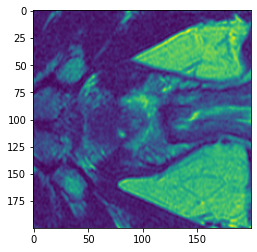

In [ ]:
plt.imshow(l[0,0])

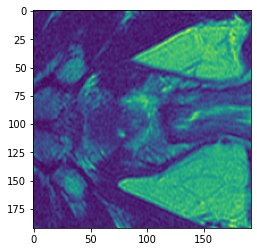

In [ ]:
plt.imshow(f[0][0,0])

# Pytorch

## Resnet Block



In [ ]:

def model_parameters_numel(model):
    list_sum = []
    for p in model.parameters():
        list_sum.append(p.data.numel())
    return sum(list_sum)
        


In [ ]:
class resnet_block(nn.Module):
    
    def __init__(self, input_activation, intermediate, expand = 1, stride = 1, down = None):
        super().__init__()
        self.expand = expand
        output = intermediate * self.expand
        self.conv1x1_1 = nn.Conv2d(input_activation, intermediate, 1)
        self.BN1 = nn.BatchNorm2d(intermediate)
        
        self.conv3x3 =  nn.Conv2d(intermediate, intermediate, 3, stride=stride, padding=1)
        self.BN2 = nn.BatchNorm2d(intermediate)

        self.conv1x1_2 =  nn.Conv2d(intermediate, output, 1)
        self.BN3 = nn.BatchNorm2d(output)
       
        self.down = nn.Conv2d(input_activation, output, 1, stride=stride)
        
    def forward(self , inp):
        inp1 = inp
        c = F.relu(self.BN1(self.conv1x1_1(inp)))
        c = F.relu(self.BN2(self.conv3x3(c)))
        c = F.relu(self.BN3(self.conv1x1_2(c)))
        if self.down!=None:
            inp1 = self.down(inp)
        out = F.relu(c + inp1) 
        
        return out

In [ ]:
        
class Unet(nn.Module):
    def __init__(self, n_class):

        
        
      super().__init__()
      self.inp = nn.Conv2d(1,16,3,padding=1)
      self.en_block1 = resnet_block(16,32)
      self.en_block2 = resnet_block(32,64)
      self.en_block3 = resnet_block(64,128)
      self.en_block4 = resnet_block(128,256)
      self.en_block5 = resnet_block(256,512)
      self.en_block6 = resnet_block(512, 1024)

        
      self.transpose5 = nn.ConvTranspose2d(1024,512,2,2)
      self.transpose4 = nn.ConvTranspose2d(512,256,2,2)

      self.transpose3 = nn.ConvTranspose2d(256,128,2,2)
      self.transpose2 = nn.ConvTranspose2d(128,64,2,2)
      self.transpose1 = nn.ConvTranspose2d(64,32,2,2)
        
      self.de_block1 = resnet_block(64,32)
      self.de_block2 = resnet_block(128,64)
      self.de_block3 = resnet_block(256,128)

      self.de_block4 = resnet_block(512, 256)
      self.de_block5 = resnet_block(1024, 512)
      self.out_conv = nn.Conv2d(32, n_class, 1)

        
    

    def forward(self, inp):
      inp  = self.inp(inp)
      el1 = self.en_block1(inp) #  (32,h,w)
      max1 = nn.MaxPool2d(2)(el1) # (32,h//2, w//2)

      el2 = self.en_block2(max1)    #(64, h//2, w//2)

      max2 = nn.MaxPool2d(2)(el2)  #(64, h//4, w//4)

      el3 = self.en_block3(max2)    #(128, h//4, w//4)

      max3 = nn.MaxPool2d(2)(el3)  #(128, h//8, w//8)


      el4 = self.en_block4(max3)    #(256, h//8, w//8)

      max4 = nn.MaxPool2d(2)(el4)  #(256, h//16, w//16)

      el5 = self.en_block5(max4)  #(512, h//16, w//16)

      max5 = nn.MaxPool2d(2)(el5)  #(512, h//32, w//32)

        
      el6 = self.en_block6(max5)  #(1024, h//32, w//32)


      tl5 = self.transpose5(el6)  #(512, h//16, w//16)

      cat5 = torch.cat([tl5, el5], 1) #(1024, h//16, h//16 )

      d5 =  self.de_block5(cat5)      #(512, h//16, w//16

        
      tl4 = self.transpose4(d5)       #(256, h//8, w//8)
      cat4 = torch.cat([tl4, el4], 1) #(512, h//8, w//8)
      d4 =  self.de_block4(cat4)     #(256, h//8, w//8)
        
      tl3 = self.transpose3(d4)        #(128, h//4, w//4)
      cat3 = torch.cat([tl3, el3], 1)  #(256, h//4, w//4)
      d3 =  self.de_block3(cat3)        #(128, h//4, w//4)
        
        
      tl2 = self.transpose2(d3)          #(64, h//2, w//2)
      cat2 = torch.cat([tl2, el2], 1)   #(128, h//2, w//2)
      d2 =  self.de_block2(cat2)         #(64, h//2, w//2)
        
      tl1 = self.transpose1(d2)          #(32, h, w)
      cat1 = torch.cat([tl1, el1], 1) #(64, h, w)
      d1 =  self.de_block1(cat1)        #(32, h, w)
      output = torch.sigmoid(self.out_conv(d1)) 

      return output

In [ ]:
g = Unet(1)

In [ ]:
model_parameters_numel(g)

23088673

In [ ]:
def dice_coef_loss(inputs, target):
    smooth = 0.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    inputs = inputs.to(device)
    target = inputs.to(device)

    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = dice_coef_loss(inputs, target)

    return bceloss + dicescore

In [ ]:
device = torch.device('cuda')

In [ ]:
def train_step(model, loss = None, device = device, epochs = 30, decay = True, lr = 0.001, best_valid = 0.0):


  epochs = epochs
  Loss = dice_coef_loss
  model.to(device)
  opt = torch.optim.Adam(model.parameters(), lr=lr)
  for epoch in range(epochs):
    loss_item = []
    val_item = []

    num_batch = 1
    num_batch_v = 1


    for batch, (image, segment) in enumerate(x):
      num_batch+= batch
      image = image.to(device)
      segment = segment.to(device)


      seg_hat = model(image)
      loss = Loss(seg_hat, segment)
      loss_item.append(loss.item())

      opt.zero_grad()
      loss.backward()
      opt.step()

    
      

    mean_loss = sum(loss_item)/num_batch
    print(f'Loss in epoch{epoch} is :', mean_loss)


 

    #if valid >= best_valid:

    #torch.save(model.state_dict(), os.path.join(root, "model.pt"))




In [ ]:
train_step(g)

Loss in epoch0 is : 0.0064803905019136234
Loss in epoch1 is : 0.006238862906939515


KeyboardInterrupt: ignored

In [ ]:
f = iter(x).__next__()

In [ ]:
yhat = g(f[0].to(device))

RuntimeError: ignored

In [ ]:
f[1][0,0]

array([0., 1.], dtype=float32)

## Attention

In [ ]:
class conv_block(nn.Module):
    
    def __init__(self, input_activation, output_activation):
        
        super().__init__()
        self.conv1 = nn.Conv2d(input_activation, output_activation, 3, padding=1)
        self.BN1 = nn.BatchNorm2d(output_activation)
        self.conv2 = nn.Conv2d(input_activation, output_activation, 3, padding=1)
        self.BN2 = nn.BatchNorm2d(output_activation)


        
    def forward(self, x):
        l = self.conv1(x)
        l = F.relu(self.BN1(l))
        l = self.conv2(l)
        l = F.relu(self.BN2(l))
        return l

In [ ]:


class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

In [ ]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


In [ ]:

class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

## Traditinal

In [ ]:
train_image_torch = np.expand_dims(train,1)
train_seg_torch  = np.expand_dims(train_seg_f,1)

In [ ]:
dataloader_image = torch.utils.data.DataLoader(train_image_torch,32)
dataloader_segment = torch.utils.data.DataLoader(train_seg_torch,32)

In [ ]:
class conv_block(nn.Module):
    
    def __init__(self, input_activation, output_activation):
        
        super().__init__()
        self.conv1 = nn.Conv2d(input_activation, output_activation, 3, padding=1)
        self.BN1 = nn.BatchNorm2d(output_activation)
        self.conv2 = nn.Conv2d(output_activation, output_activation, 3, padding=1)
        self.BN2 = nn.BatchNorm2d(output_activation)


        
    def forward(self, x):
        l = self.conv1(x)
        l = F.relu(self.BN1(l))
        l = self.conv2(l)
        l = F.relu(self.BN2(l))
        return l


In [ ]:


class Unet(nn.Module):
    def __init__(self, n_class):
        
        super().__init__()
        self.en_block1 = conv_block(1,32)
        self.en_block2 = conv_block(32,64)
        self.en_block3 = conv_block(64,128)
        self.en_block4 = conv_block(128,256)
        self.en_block5 = conv_block(256,512)
        self.en_block6 = conv_block(512, 1024)

        
        self.transpose5 = nn.ConvTranspose2d(1024,512,2,2)
        self.transpose4 = nn.ConvTranspose2d(512,256,2,2)

        self.transpose3 = nn.ConvTranspose2d(256,128,2,2)
        self.transpose2 = nn.ConvTranspose2d(128,64,2,2)
        self.transpose1 = nn.ConvTranspose2d(64,32,2,2)
        
        self.de_block1 = conv_block(64,32)
        self.de_block2 = conv_block(128,64)
        self.de_block3 = conv_block(256,128)

        self.de_block4 = conv_block(512, 256)
        self.de_block5 = conv_block(1024, 512)
        self.out_conv = nn.Conv2d(32, 1, 1)

        
    

    def forward(self, inp):
        el1 = self.en_block1(inp) #  (32,h,w)
        #print('el1',el1.shape)
        max1 = nn.MaxPool2d(2)(el1) # (32,h//2, w//2)
        #print('max1',max1.shape)

        el2 = self.en_block2(max1)    #(64, h//2, w//2)
        #print('el2',el2.shape)

        max2 = nn.MaxPool2d(2)(el2)  #(64, h//4, w//4)
        #print('max2',max2.shape)

        el3 = self.en_block3(max2)    #(128, h//4, w//4)
        #print('el3',el3.shape)

        max3 = nn.MaxPool2d(2)(el3)  #(128, h//8, w//8)
        #print('max3',max3.shape)


        el4 = self.en_block4(max3)    #(256, h//8, w//8)
        #print('el4',el4.shape)

        max4 = nn.MaxPool2d(2)(el4)  #(256, h//16, w//16)
        #print('max4',max4.shape)

        el5 = self.en_block5(max4)  #(512, h//16, w//16)
        #print('el5',el5.shape)

        max5 = nn.MaxPool2d(2)(el5)  #(512, h//32, w//32)
        #print('max5',max5.shape)

        
        el6 = self.en_block6(max5)  #(1024, h//32, w//32)
        #print('el6',el6.shape)


        tl5 = self.transpose5(el6)  #(512, h//16, w//16)
        #print('tl5',tl5.shape)

        cat5 = torch.cat([tl5, el5], 1) #(1024, h//16, h//16 )
        #print('cat5',cat5.shape)

        d5 =  self.de_block5(cat5)      #(512, h//16, w//16
        #print('d5',d5.shape)

        
        tl4 = self.transpose4(d5)       #(256, h//8, w//8)
        cat4 = torch.cat([tl4, el4], 1) #(512, h//8, w//8)
        d4 =  self.de_block4(cat4)     #(256, h//8, w//8)
        
        tl3 = self.transpose3(d4)        #(128, h//4, w//4)
        cat3 = torch.cat([tl3, el3], 1)  #(256, h//4, w//4)
        d3 =  self.de_block3(cat3)        #(128, h//4, w//4)
        
        
        tl2 = self.transpose2(d3)          #(64, h//2, w//2)
        cat2 = torch.cat([tl2, el2], 1)   #(128, h//2, w//2)
        d2 =  self.de_block2(cat2)         #(64, h//2, w//2)
        
        tl1 = self.transpose1(d2)          #(32, h, w)
        cat1 = torch.cat([tl1, el1], 1) #(64, h, w)
        d1 =  self.de_block1(cat1)        #(32, h, w)
        output = torch.sigmoid(self.out_conv(d1)) 

        return output


In [ ]:
model = Unet(1)

In [ ]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    inputs = inputs.to(device)
    target = inputs.to(device)

    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = dice_coef_loss(inputs, target)

    return bceloss + dicescore

In [ ]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [ ]:
device = torch.device('cuda')

In [ ]:
loss=None

In [ ]:
Loss = bce_dice_loss if loss==None else loss


In [ ]:
def train_step(model, loss = None, device = device, epochs = 30, decay = True, lr = 0.001, best_valid = 0.0):


  epochs = epochs
  Loss = bce_dice_loss if loss==None else loss
  model.to(device)
  opt = torch.optim.Adam(model.parameters(), lr=lr)
  loss_item = []
  for epoch in range(epochs):

    num_batch = 1

    for batch, (image, segment) in enumerate(zip(dataloader_image, dataloader_segment)):
      num_batch+= batch
      image = image.to(device)
      segment = segment.to(device)


      seg_hat = model(image)
      loss = Loss(seg_hat, segment)

      opt.zero_grad()
      loss.backward()
      opt.step()
      loss_item.append(loss.item())

    mean_loss = sum(loss_item)/num_batch
    print(f'Loss in epoch{epoch} is :', mean_loss)
 

    #if valid >= best_valid:

    #torch.save(model.state_dict(), os.path.join(root, "model.pt"))




In [ ]:
train_step(model,loss = nn.BCELoss())

RuntimeError: ignored

In [ ]:
for epoch in range(20):
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
        
        for i_step, (data, target) in enumerate(zip(dataloader_image, dataloader_segment)):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)
            opt.zero_grad()
            loss.backward()
            opt.step()

        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean())
    
           
 
       

RuntimeError: ignored

In [ ]:
for epoch in range(ep):
  for im , segi in zip(d_tr, d_seg):
    im = im.to(device=device)
    segi =segi.to(device)
    yh = m(im)
    l = loss(yh, segi)
    opt.zero_grad()
    l.backward()
    opt.step()
  print(f"epoch{epoch} loss is :", l)

epoch30 loss is : tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch30 loss is : tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch30 loss is : tensor(0.5307, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
epoch30 loss is : tensor(0.5326, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


KeyboardInterrupt: ignored

In [ ]:
torch.cuda.current_device()


0

In [ ]:
torch.cuda.is_available()

True

# tensorflow

In [ ]:
im_add = []
seg_add = []

    
root = '/content/drive/MyDrive/qazal/new_data'

for en,i in enumerate(os.walk(root)):
  if en==0:
    continue
  patients_list = glob.glob(i[0] + '/' + '*[0-9].*')
  patients_list.sort()


  im_add.extend(patients_list)



  segment_list = glob.glob(i[0] + '/' + '*n.*')
  segment_list.sort()
  seg_add.extend(segment_list)

crop_size = 192
p_seg = []
p_im = []
for patient_file, segment_file in zip( im_add, seg_add):
  im = nib.load(patient_file).get_fdata()  

  Masks = nib.load(segment_file).get_fdata()     
  for  j in range(Masks.shape[2]):
    k=make_box(Masks[:,:,j].astype(np.bool))
    if len(k['bbox_bool'])!=0:
      crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
      p_seg.append(crop)
      p_im.append(crop_im)
image_numpy = np.stack(p_im, 0)
image_numpy = image_numpy/image_numpy.max()
image_numpy = np.float32(image_numpy)

image_numpy = np.expand_dims(image_numpy,3)

segment_numpy = np.stack(p_seg,0)

segment_numpy = segment_numpy.astype(bool)
segment_numpy = np.float32(segment_numpy)
segment_numpy = np.expand_dims(segment_numpy,3)


In [ ]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS  =crop_size, crop_size, 1

In [ ]:
class conv_block(tf.keras.layers.Layer):

  def __init__(self, channel, **kwargs):
        super(conv_block, self).__init__(**kwargs)
        self.c1x1 = layers.Conv2D(channel, (1,1), activation='relu', kernel_initializer='he_normal',
                padding='same')
        self.c3x3 = layers.Conv2D(channel, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')
        self.c1x1_2 = layers.Conv2D(channel, (1,1), activation='relu', kernel_initializer='he_normal',
                padding='same')
        self.co =  layers.Conv2D(channel, (1,1), activation='relu', kernel_initializer='he_normal',
                padding='same')


  def call(self, inputs, training=None):
    l1 = self.c1x1(inputs)
    l1 = self.c3x3(l1)
    l1 = self.c1x1_2(l1)
    inp_mod = self.co(inputs)
    out = l1 + inp_mod
    return out
        

In [ ]:
input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
drop = None
l2 = True

In [ ]:
    
inputs = tf.keras.Input(input_size)
    
    
c1=conv_block(16)(inputs)
p1 = layers.MaxPooling2D((2,2))(c1)


c2 = conv_block(32)(p1)
p2 = layers.MaxPooling2D((2,2))(c2)


c3 = conv_block(64)(p2)
p3 = layers.MaxPooling2D((2,2))(c3)


c4 = conv_block(128)(p3)
p4 = layers.MaxPooling2D((2,2))(c4)


c5 = conv_block(256)(p4)
p5 = layers.MaxPooling2D((2,2))(c5)

c6 = conv_block(256)(p5)



u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
u7 = layers.concatenate([u7, c5])
c7 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)

c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7)   

u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)   


u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7) 

u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)
c8 = layers.Dropout(0.1)(c8)
c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c8) 
    
    
u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = layers.concatenate([u9, c1], axis = 3)
c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)
c9 = layers.Dropout(0.1)(c9)
c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9) 
    
outputs = layers.Conv2D(1,(1,1), activation="softmax",)(c9)
    
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
conv_block_6 (conv_block)       (None, 192, 192, 16) 2656        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 96, 96, 16)   0           conv_block_6[0][0]               
__________________________________________________________________________________________________
conv_block_7 (conv_block)       (None, 96, 96, 32)   11392       max_pooling2d_5[0][0]            
____________________________________________________________________________________________

In [ ]:
def Dice(y_true, y_pred):

    
    
  #mask1 = tf.math.argmax(y_pred, axis=-1)

  y_pred= tf.cast(mask1, tf.float32)
  inter = tf.reduce_sum(tf.multiply(y_pred , y_true), [1,2])
  uni = tf.reduce_sum(y_pred , [1,2])+ tf.reduce_sum( y_true, [1,2])

  des = tf.reduce_mean(2*inter/uni)
       
  return 1.- des



In [ ]:
def Dice1(y_true, y_pred):

    
    
  mask1 = tf.math.argmax(y_pred, axis=-1)

  y_pred= tf.cast(mask1, tf.float32)
  inter = tf.reduce_sum(y_pred * y_true, [1,2])
  uni = tf.reduce_sum(y_pred , [1,2])+ tf.reduce_sum( y_true, [1,2])

  des = tf.reduce_mean(2*inter/uni)
       
  return des



In [ ]:
optimizer = tf.keras.optimizers.Adam()


In [ ]:
cross = "sparse_categorical_crossentropy"

In [ ]:
model.compile(optimizer=optimizer, loss=Dice , metrics=[Dice1])
                 

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * 0.1



In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
results = model.fit(image_numpy, segment_numpy,
                    shuffle = True,
                    validation_split = 0.1,
                    batch_size=32,
                    epochs=70)

In [ ]:
loss = results.history['loss']
val_loss = results.history['val_Dice']

epochs = range(70)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss Cross entropy')
plt.plot(epochs, val_loss, 'bo', label='Validation Dice Metric')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

pr = model.predict(test_image[:7])

In [ ]:
mask1 = np.argmax(pr[2], axis=-1)
plt.imshow(mask1)


In [ ]:
plt.imshow(test_seg_f[2])


# Trad

In [ ]:
im_add = []
seg_add = []

    
root = '/content/drive/MyDrive/qazal/new_data'

for en,i in enumerate(os.walk(root)):
  if en==0:
    continue
  patients_list = glob.glob(i[0] + '/' + '*[0-9].*')
  patients_list.sort()


  im_add.extend(patients_list)



  segment_list = glob.glob(i[0] + '/' + '*n.*')
  segment_list.sort()
  seg_add.extend(segment_list)

crop_size = 192
p_seg = []
p_im = []
for patient_file, segment_file in zip( im_add, seg_add):
  im = nib.load(patient_file).get_fdata()  

  Masks = nib.load(segment_file).get_fdata()     
  for  j in range(Masks.shape[2]):
    k=make_box(Masks[:,:,j].astype(np.bool))
    if len(k['bbox_bool'])!=0:
      crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
      p_seg.append(crop)
      p_im.append(crop_im)
image_numpy = np.stack(p_im, 0)
image_numpy = image_numpy/image_numpy.max()
image_numpy = np.float32(image_numpy)

image_numpy = np.expand_dims(image_numpy,3)

segment_numpy = np.stack(p_seg,0)

segment_numpy = segment_numpy.astype(bool)
segment_numpy = np.float32(segment_numpy)
segment_numpy = np.expand_dims(segment_numpy,3)


In [37]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self):

    self.image = [os.path.join('/content/drive/MyDrive/qazal/slice',i) for i in os.listdir('/content/drive/MyDrive/qazal/slice')]
    self.seg = [os.path.join('/content/drive/MyDrive/qazal/slice_seg',i) for i in os.listdir('/content/drive/MyDrive/qazal/slice_seg')]

  def __len__(self):
    'Get the number of batches per epoch'

    return len(self.image)

  def __getitem__(self, index):
    im = nib.load(self.image[index]).get_fdata()  

    Masks = nib.load(self.seg[index]).get_fdata() 
    if len(np.unique(Masks)) >1:

      k=make_box(Masks[:,:].astype(np.bool))
      crop_im , crop = crop_specific(im[:,:], Masks[:,:], crop_size= 192)
      return crop_im, crop

       

    

 

In [38]:
dat = DataGenerator()

In [45]:
dat

In [2]:
for i in os.walk('/content/drive/MyDrive/qazal/slice'):
  print(i)

NameError: ignored

In [21]:
im=[os.path.join('/content/drive/MyDrive/qazal/slice',i) for i in os.listdir('/content/drive/MyDrive/qazal/slice')]

In [6]:
seg =  [os.path.join('/content/drive/MyDrive/qazal/slice_seg',i) for i in os.listdir('/content/drive/MyDrive/qazal/slice_seg')]


In [15]:
Masks = nib.load(seg[0]).get_fdata()     

NameError: ignored

In [ ]:
def U_Net_Segmentation(input_size=(192, 192, 1)):
    
    inputs = tf.keras.Input(input_size)
    
    
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)


    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)


    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)


    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)


    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c5)



    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)   


    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7) 

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c8) 
    
    
    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis = 3)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9) 
    
    outputs = layers.Conv2D(1,(1,1), activation="softmax",)(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    return model

In [ ]:
def Dice(y_true, y_pred):

    
    
  mask1 = tf.math.argmax(y_pred, axis=-1)

  y_pred= tf.cast(mask1, tf.float32)
  inter = tf.reduce_sum(y_pred * y_true, [1,2])
  uni = tf.reduce_sum(y_pred , [1,2])+ tf.reduce_sum( y_true, [1,2])

  des = tf.reduce_mean(2*inter/uni)
       
  return des

model = U_Net_Segmentation()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 192, 192, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 192, 192, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 192, 192, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [ ]:
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))


In [ ]:

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [ ]:
def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator/ denominator

In [ ]:
#loss = "sparse_categorical_crossentropy"
loss = dice_loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()


In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[Dice])
                 

In [ ]:
results = model.fit(image_numpy, segment_numpy,
                    shuffle = True,
              validation_split = 0.1,
                    batch_size=32,
                    epochs=70)

In [ ]:
image_numpy = np.squeeze(image_numpy)

In [ ]:
segment_numpy = np.squeeze(segment_numpy)